In [246]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.special import kolmogi
from scipy.stats import uniform

In [65]:
%reload_ext pycodestyle_magic

In [242]:
%pycodestyle_off

In [6]:
cats_df = pd.read_csv('сorrect_cats.csv')
cats_df = cats_df[['Sex', 'Bwt', 'Hwt']]
cats_males = cats_df.loc[cats_df['Sex'] == 'M']
cats_females = cats_df.loc[cats_df['Sex'] == 'F']

In [7]:
cats_df

,Sex,Bwt,Hwt
0,F,2.0,7.0
1,F,2.0,7.4
2,F,2.0,9.5
3,F,2.1,7.2
4,F,2.1,7.3
...,...,...,...
139,M,3.7,11.0
140,M,3.8,14.8
141,M,3.8,16.8
142,M,3.9,14.4


# №1

Доверительные интервалы для оценки среднего с помощью непараметрических bootstrap методов:

1) pivotal

2) percentile

3) stundentized pivotal

In [247]:
def bootstrap_sampler(data: list, num_of_samples: int):
    bootstrap_samples = list()
    for _ in range(num_of_samples):
        new_bootstrap_sample = np.random.choice(data, len(data))
        bootstrap_samples.append(new_bootstrap_sample)
    return bootstrap_samples


def mean_pivotal_boostrap(data: list, alpha: float, num_of_samples: int):
    bootstrap_samples = bootstrap_sampler(data, num_of_samples)
    bootstrap_estimations = list(map(np.mean, bootstrap_samples))
    bootstrap_estimations = np.array(bootstrap_estimations)
    mean_estimation = np.mean(data)
    bootstrap_estimations = 2 * mean_estimation - bootstrap_estimations
    bootstrap_estimations.sort()
    lower_quantile = math.floor(alpha/2 * num_of_samples)
    upper_quantile = math.floor((1-alpha/2) * num_of_samples)
    lower_bound = bootstrap_estimations[lower_quantile]
    lower_bound = round(lower_bound, 3)
    upper_bound = bootstrap_estimations[upper_quantile]
    upper_bound = round(upper_bound, 3)
    return (lower_bound, upper_bound)


def mean_percentile_boostrap(data: list, alpha: float, num_of_samples: int):
    bootstrap_samples = bootstrap_sampler(data, num_of_samples)
    bootstrap_estimations = list(map(np.mean, bootstrap_samples))
    bootstrap_estimations.sort()
    lower_quantile = math.floor(alpha/2 * num_of_samples)
    upper_quantile = math.floor((1-alpha/2) * num_of_samples)
    lower_bound = bootstrap_estimations[lower_quantile]
    lower_bound = round(lower_bound, 3)
    upper_bound = bootstrap_estimations[upper_quantile]
    upper_bound = round(upper_bound, 3)
    return (lower_bound, upper_bound)


def mean_bootstrap_standard_error(var_data: list, num_of_samples: int):
    bootstrap_samples = bootstrap_sampler(var_data, num_of_samples)
    var_list = [(np.mean(sample) - np.mean(var_data))**2
                for sample in bootstrap_samples]
    variance = np.mean(var_list)
    standart_error = np.sqrt(variance) / np.sqrt(num_of_samples)
    return standart_error


def mean_studentized_pivotal(data: list, alpha: float, num_of_samples: int):
    mean_data = np.mean(data)
    data_standard_error = mean_bootstrap_standard_error(data, num_of_samples)
    bootstrap_samples = bootstrap_sampler(data, num_of_samples)
    standard_error_list = [mean_bootstrap_standard_error(sample, num_of_samples)
                           for sample in bootstrap_samples]
    centralized_samples = np.mean(bootstrap_samples, axis=1) - mean_data
    normalized_samples = centralized_samples / standard_error_list
    normalized_samples.sort()
    lower_quantile = math.floor((1-alpha/2) * num_of_samples)
    upper_quantile = math.floor((alpha/2) * num_of_samples)
    lower_bound = mean_data - normalized_samples[lower_quantile]*data_standard_error
    lower_bound = round(lower_bound, 3)
    upper_bound = mean_data - normalized_samples[upper_quantile]*data_standard_error
    upper_bound = round(upper_bound, 3)
    return (lower_bound, upper_bound)

In [248]:
alpha = 0.05
num_of_samples = 100
male_pivotal = mean_pivotal_boostrap(cats_males['Hwt'],
                                     alpha, num_of_samples)
male_percentile = mean_percentile_boostrap(cats_males['Hwt'],
                                           alpha, num_of_samples)
male_studentized_pivotal = mean_studentized_pivotal(cats_males['Hwt'],
                                                    alpha, num_of_samples)
female_pivotal = mean_pivotal_boostrap(cats_females['Hwt'],
                                       alpha, num_of_samples)
female_percentile = mean_percentile_boostrap(cats_females['Hwt'],
                                             alpha, num_of_samples)
female_studentized_pivotal = mean_studentized_pivotal(cats_females['Hwt'],
                                                      alpha, num_of_samples)
print('male mean: {:.3f}'.format(np.mean(cats_males['Hwt'])))
print('male pivotal:',  male_pivotal)
print('male percentile:', male_percentile)
print('male studentized pivotal', male_studentized_pivotal)
print('female mean: {:.3f}'.format(np.mean(cats_females['Hwt'])))
print('female pivotal:', female_pivotal)
print('female percentile:', female_percentile)
print('female studentized pivotal', female_studentized_pivotal)

male mean: 11.323
male pivotal: (10.632, 11.78)
male percentile: (10.826, 11.813)
male studentized pivotal (10.863, 11.756)
female mean: 9.202
female pivotal: (8.7, 9.589)
female percentile: (8.883, 9.685)
female studentized pivotal (8.881, 9.487)


# №2

In [211]:
def uniform_kde(x, data, bw):
    kde_list = [uniform.pdf((x-value) / bw, loc=-1, scale=2) / bw for value in data]
    return np.mean(kde_list)

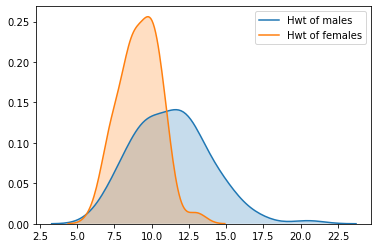

In [230]:
sns.kdeplot(data=cats_males['Hwt'], shade=True,  label='Hwt of males')
sns.kdeplot(data=cats_females['Hwt'], shade=True,  label='Hwt of females')

In [220]:
data_males = cats_males['Hwt']

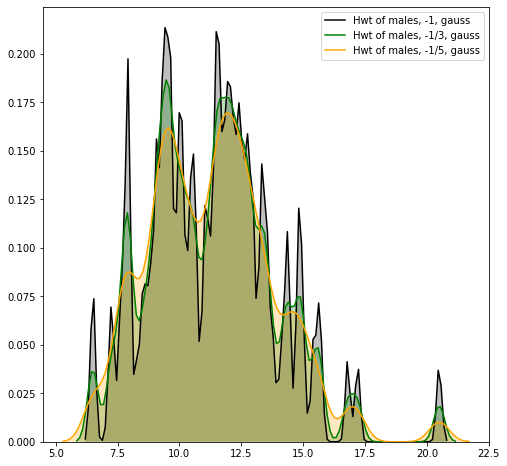

In [236]:
plt.figure(figsize=(8, 8))
sns.kdeplot(data=data_males, shade=True, color='black', kernel='gau',
            label='Hwt of males, -1, gauss', bw=pow(len(data_males), -1/2))
sns.kdeplot(data=data_males, shade=True, color='green', kernel='gau',
            label='Hwt of males, -1/3, gauss', bw=pow(len(data_males), -1/3))
sns.kdeplot(data=data_males, shade=True, color='orange', kernel='gau',
            label='Hwt of males, -1/5, gauss', bw=pow(len(data_males), -1/5))

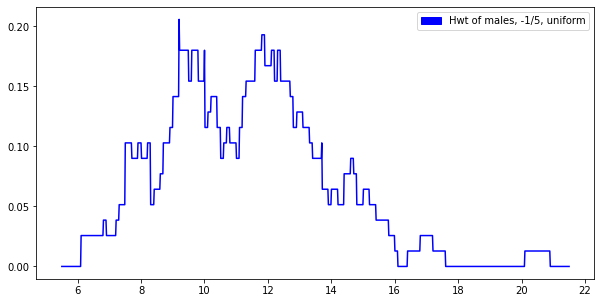

In [237]:
x = np.linspace(min(data_males) - 1, max(data_males) + 1, 1000)
y = [uniform_kde(x, data_males, pow(len(data_males), -1/5)) for x in x]
blue_patch = mpatches.Patch(color='blue', label='Hwt of males, -1/5, uniform')
plt.figure(figsize=(10, 5))
plt.legend(handles=[blue_patch], loc='upper right')
plt.plot(x, y, 'b')

In [228]:
data_females = cats_females['Hwt']

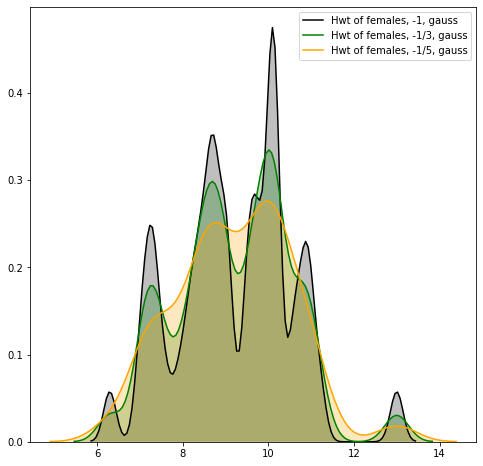

In [240]:
plt.figure(figsize=(8, 8))
sns.kdeplot(data=data_females, shade=True, color='black', kernel='gau',
            label='Hwt of females, -1, gauss',
            bw=pow(len(data_females), -1/2))
sns.kdeplot(data=data_females, shade=True, color='green', kernel='gau',
            label='Hwt of females, -1/3, gauss',
            bw=pow(len(data_females), -1/3))
sns.kdeplot(data=data_females, shade=True, color='orange', kernel='gau',
            label='Hwt of females, -1/5, gauss',
            bw=pow(len(data_females), -1/5))

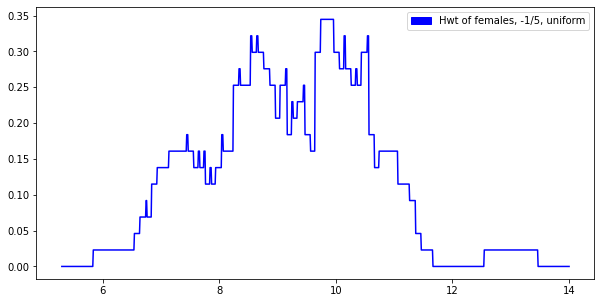

In [243]:
x = np.linspace(min(data_females) - 1, max(data_females) + 1, 1000)
y = [uniform_kde(x, data_females, pow(len(data_females), -1/5)) for x in x]
blue_patch = mpatches.Patch(color='blue', 
                            label='Hwt of females, -1/5, uniform')
plt.figure(figsize=(10, 5))
plt.legend(handles=[blue_patch], loc='upper right')
plt.plot(x, y, 'b')

# №3

Доверительные полосы для функции распределения:

1) Асимптотическая с помощью теоремы Колмогорова (по факту ее использовать нельзя, так как распределение не непрерывное)

2) Точная с помощью неравенства Дворецкого-Кифера-Вольфовитца

In [5]:
data = np.array(cats_df['Bwt'])

In [3]:
# Dvoretzky–Kiefer–Wolfowitz
def dkv_conf_interval(x: float, data: list, alpha: float):
    data_size = len(data)
    eps = math.sqrt(-math.log(0.5*alpha) / (2*data_size))
    lower_bound = max(ECDF(data)(x) - eps, 0)
    upper_bound = min(ECDF(data)(x) + eps, 1)
    return (lower_bound, upper_bound)


def kolmogorov_conf_interval(x: float, data: list, alpha: float):
    data_size = len(data)
    lower_bound = max(ECDF(data)(x) -
                      kolmogi(alpha)/math.sqrt(data_size), 0)
    upper_bound = min(ECDF(data)(x) +
                      kolmogi(alpha)/math.sqrt(data_size), 1)
    return (lower_bound, upper_bound)

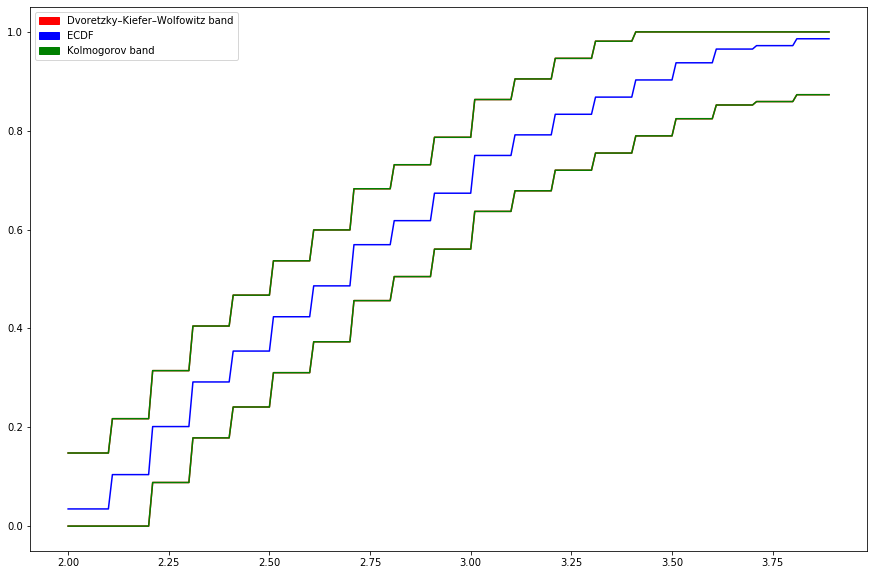

In [8]:
x = np.arange(min(data), max(data), 0.01)
dkv_lower_bound_values = [dkv_conf_interval(x_val, data, 0.05)[0]
                          for x_val in x]
dkv_upper_bound_values = [dkv_conf_interval(x_val, data, 0.05)[1]
                          for x_val in x]
kolm_lower_bound_values = [kolmogorov_conf_interval(x_val, data, 0.05)[0]
                           for x_val in x]
kolm_upper_bound_values = [kolmogorov_conf_interval(x_val, data, 0.05)[1]
                           for x_val in x]
plt.figure(figsize=(15, 10))
red_patch = mpatches.Patch(color='red',
                           label='Dvoretzky–Kiefer–Wolfowitz band')
green_patch = mpatches.Patch(color='green', label='Kolmogorov band')
blue_patch = mpatches.Patch(color='blue', label='ECDF')
plt.legend(handles=[red_patch, blue_patch, green_patch], loc='upper left')
plt.plot(x, dkv_lower_bound_values, 'r')
plt.plot(x, ECDF(data)(x), 'b')
plt.plot(x, dkv_upper_bound_values, 'r')
plt.plot(x, kolm_lower_bound_values, 'g')
plt.plot(x, kolm_upper_bound_values, 'g')
plt.show()